In [1]:
import os
import random
from tqdm import tqdm
import urllib.request
import zipfile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [ ]:
import nltk
from nltk.corpus import treebank
from nltk.tree import Tree

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix

In [ ]:
import optuna
from optuna.trial import TrialState

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### StackedTransformerEncoder

#### Seed Setting

```markdown
In here, the code sets the random seed for reproducibility across random, NumPy, and PyTorch operations. This ensures consistent results by fixing the seed for both CPU and GPU computations.
```

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

#### Data Loading

```markdown
In here, the code loads the parsed sentences from the Penn Treebank corpus, converting them into a list of tree structures for further processing.
```

In [4]:
trees = list(treebank.parsed_sents())

#### Frequency Counting

```markdown
In here, the code iterates through each tree to count the frequency of words and POS tags. It stores these counts in dictionaries to facilitate vocabulary construction.
```

In [5]:
word_freq = defaultdict(int)
pos_freq = defaultdict(int)

In [6]:
for tree in trees:
    for subtree in tree.subtrees():
        if subtree.height() == 2:
            word = subtree.leaves()[0].lower()
            pos = subtree.label()
            word_freq[word] += 1
            pos_freq[pos] += 1

#### Vocabulary Building

```markdown
In here, the code constructs mappings from words and POS tags to unique indices, including special tokens for padding and unknown words. It also creates reverse mappings for later use in decoding predictions.
```

In [7]:
min_freq = 2

word2idx = {'<PAD>': 0, '<UNK>': 1}
for word, freq in word_freq.items():
    if freq >= min_freq:
        word2idx[word] = len(word2idx)
        
pos2idx = {'<PAD>': 0}
for pos, freq in pos_freq.items():
    pos2idx[pos] = len(pos2idx)

In [8]:
idx2word = {idx: word for word, idx in word2idx.items()}
idx2pos = {idx: pos for pos, idx in pos2idx.items()}

#### Embedding Loading

```markdown
In here, the code defines a function to load pre-trained GloVe embeddings. It initializes an embedding matrix with random values and replaces them with GloVe vectors for words present in the vocabulary.
```

In [9]:
def download_glove(glove_url, download_path, extract_to):
    urllib.request.urlretrieve(glove_url, download_path)
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
def load_glove_embeddings(glove_file_path, embedding_dim, word2idx):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    embeddings[word2idx['<PAD>']] = np.zeros(embedding_dim)

    glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
    glove_zip_path = os.path.join(os.path.dirname(glove_file_path), "glove.6B.zip")
    glove_dir = os.path.dirname(glove_file_path)

    if not os.path.isfile(glove_file_path):
        if not os.path.exists(glove_dir):
            os.makedirs(glove_dir)
        download_glove(glove_url, glove_zip_path, glove_dir)

    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line_num, line in enumerate(f):
            values = line.strip().split()
            if not values:
                continue
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            if word in word2idx:
                embeddings[word2idx[word]] = vector

    return torch.tensor(embeddings, dtype=torch.float32)

In [10]:
embedding_dim = 200
embedding_matrix = load_glove_embeddings("../../data/glove.6B.200d/glove.6B.200d.txt", embedding_dim, word2idx)

#### Dataset and DataLoader

```markdown
In here, the code defines a custom dataset class for the Treebank data and a collate function to handle batching and padding. It splits the data into training and validation sets and creates corresponding DataLoader instances.
```

In [11]:
class TreebankDataset(Dataset):
    def __init__(self, trees, word2idx, pos2idx):
        self.trees = trees
        self.word2idx = word2idx
        self.pos2idx = pos2idx

    def __len__(self):
        return len(self.trees)

    def __getitem__(self, idx):
        tree = self.trees[idx]
        words = [word.lower() for word in tree.leaves()]
        pos_tags = [subtree.label() for subtree in tree.subtrees() if subtree.height() == 2]
        word_indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]
        pos_indices = [self.pos2idx.get(tag, self.pos2idx['<PAD>']) for tag in pos_tags]
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(pos_indices, dtype=torch.long)

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, pos_tags = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences], dtype=torch.long)
    padded_sentences = nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    padded_pos_tags = nn.utils.rnn.pad_sequence(pos_tags, batch_first=True, padding_value=pos2idx['<PAD>'])
    return padded_sentences, padded_pos_tags, lengths

In [12]:
train_trees, val_trees = train_test_split(trees, test_size=0.1, random_state=42)
train_dataset = TreebankDataset(train_trees, word2idx, pos2idx)
val_dataset = TreebankDataset(val_trees, word2idx, pos2idx)

In [13]:
batch_size = 32
train_iter = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0
)
val_iter = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=0
)

#### Encoding Definition

```markdown
In here, the code defines a positional encoding module that adds positional information to word embeddings. This helps the model understand the order of words in a sequence.
```

In [14]:
class SPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=5000):
        super(SPositionalEncoding, self).__init__()
        
        # Positional Encoding Tensor for Representing Position Information
        pe = torch.zeros(max_len, embedding_dim)
        # Tensor for Position Indices
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Divisor Term Tensor for Scaling Positions
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim))
        # Sine Component of Positional Encoding
        pe[:, 0::2] = torch.sin(position * div_term)
        # Cosine Component of Positional Encoding (Adjusted for Odd Dimensions)
        if embedding_dim % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        # Adding Batch Dimension to Positional Encoding
        pe = pe.unsqueeze(0)
        # Registering Positional Encoding as Buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Addition of Positional Encoding to Input Tensor
        x = x + self.pe[:, :x.size(1), :]
        return x

#### Model Definition

```markdown
In here, the code defines a transformer-based model for POS tagging. The model includes embedding layers, positional encoding, transformer encoder layers, dropout, and a fully connected layer for outputting POS tag probabilities.

• Token Embedding Layer
The model begins with an embedding layer that maps input token indices into dense vectors of fixed size. This layer can be initialized with a pre-trained embedding matrix, allowing the model to leverage semantic knowledge from external datasets. The embeddings are fine-tuned during training to adapt to the specific task of POS tagging. A padding index is used to handle sequences of varying lengths, ensuring that padded tokens do not affect the training process.

• Positional Encoding
Since transformers lack inherent sequential processing, a positional encoding layer (SPositionalEncoding) augments the token embeddings with positional information. This step ensures that the transformer can recognize the order of tokens in a sequence, which is critical for tasks like POS tagging where syntactic context depends on token order.

• Transformer Encoder
The transformer encoder forms the core of the model. It consists of:
- Multi-Head Self-Attention: Allows each token to attend to all others in the sequence, capturing long-range dependencies and contextual relationships.
- Feedforward Layers: Apply non-linear transformations to the outputs of the attention mechanism, enabling complex feature extraction.
- Layer Stacking: Multiple encoder layers are stacked to build a hierarchical representation of the sequence. Each layer refines the features extracted by the previous one.

• Dropout Regularization
Dropout is applied at multiple stages in the model, including:
- After the embedding and positional encoding layers.
- Within the transformer encoder to prevent overfitting during self-attention and feedforward computations.
- Before the final fully connected layer to regularize the final feature representations.

• Key Padding Mask
To ensure the model processes variable-length sequences effectively, a key padding mask is generated. This mask prevents the transformer from attending to padded tokens, maintaining the integrity of the attention mechanism and avoiding noise in the learned representations.

• Fully Connected Layer
The final layer of the model is a fully connected layer that maps the output of the transformer encoder to the desired output dimension (POS tag probabilities). Each token's contextual representation is transformed into logits, which can be further processed using a softmax function during training to compute probabilities for each POS tag.
```

In [15]:
class STransformerE(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, output_dim, padding_idx, embedding_matrix, dropout=0.1):
        super(STransformerE, self).__init__()
        
        # Embedding Layer for Token Representations
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        # Parameter Layer for Embedding Initialization w/ Pre-Trained Embedding Matrix
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = True  # Gradient Enabling for Fine-Tuning
        # Positional Encoding Layer for Input Embedding Augmentation
        self.pos_encoder = SPositionalEncoding(embedding_dim)
        # Transformer Encoder Layer for Contextual Feature Extraction
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim, 
            dropout=dropout,
            batch_first=True
        )
        # Transformer Encoder Module for Multi-Layer Encoding
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, norm=nn.LayerNorm(embedding_dim))
        # Dropout Layer for Regularization
        self.dropout = nn.Dropout(dropout)
        # Fully Connected Layer for Mapping Encoded Features to Output Dimension
        self.fc = nn.Linear(embedding_dim, output_dim)
        
        
    def forward(self, x):
        # Token Embeddings of Input Sequence
        embedded = self.embedding(x)
        # Addition of Positional Encoding to Token Embeddings
        embedded = self.pos_encoder(embedded)
        # Dropout of Embedded Tokens
        embedded = self.dropout(embedded)
        # Key Padding Mask Generation for Transformer Encoder
        src_key_padding_mask = (x == self.embedding.padding_idx)
        # Contextual Feature Extraction w/ Transformer Encoder
        transformer_output = self.transformer_encoder(
            embedded, 
            src_key_padding_mask=src_key_padding_mask
        )
        # Dropout of Transformer Output
        transformer_output = self.dropout(transformer_output)
        # Transformation of Encoded Features → Logits for POS Tags
        logits = self.fc(transformer_output)
        return logits

In [16]:
vocab_size = len(word2idx)
output_dim = len(pos2idx)
padding_idx = word2idx['<PAD>']

#### Training Function

```markdown
In here, the code defines a function to train the model for one epoch. It iterates over the training data, computes predictions, calculates loss, performs backpropagation, and updates the model parameters. It also tracks accuracy.
```

In [17]:
def train_epoch(net, iter, optimizer, criterion, device):
    net.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for sentences, pos_tags, lengths in tqdm(iter, desc="Training", leave=False):
        sentences = sentences.to(device)
        pos_tags = pos_tags.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        predictions = net(sentences)
        
        predictions = predictions.view(-1, predictions.shape[-1])
        pos_tags = pos_tags.view(-1)
        
        loss = criterion(predictions, pos_tags)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        preds = torch.argmax(predictions, dim=1)
        mask = pos_tags != pos2idx['<PAD>']
        correct += (preds[mask] == pos_tags[mask]).sum().item()
        total += mask.sum().item()
        
    accuracy = correct / total if total > 0 else 0
    return epoch_loss / len(iter), accuracy

#### Evaluation Function

```markdown
In here, the code defines a function to evaluate the model on the validation set. It computes loss and accuracy without updating the model parameters.
```

In [18]:
def evaluate_epoch(net, iter, criterion, device):
    net.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, pos_tags, lengths in tqdm(iter, desc="Evaluating", leave=False):
            sentences = sentences.to(device)
            pos_tags = pos_tags.to(device)
            lengths = lengths.to(device)
            
            predictions = net(sentences)
            predictions = predictions.view(-1, predictions.shape[-1])
            pos_tags = pos_tags.view(-1)
            
            loss = criterion(predictions, pos_tags)
            epoch_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            mask = pos_tags != pos2idx['<PAD>']
            correct += (preds[mask] == pos_tags[mask]).sum().item()
            total += mask.sum().item()
            
    accuracy = correct / total if total > 0 else 0
    return epoch_loss / len(iter), accuracy

#### Hyperparameter Tuning

```markdown
In here, the code utilizes Optuna to perform hyperparameter tuning. It defines an objective function that trains the model with different hyperparameters and returns the best validation accuracy. The study is then optimized over a specified number of trials.
```

In [19]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_heads = trial.suggest_categorical('num_heads', [4, 5, 8, 10])
    hidden_dim = trial.suggest_int('hidden_dim', 256, 1024)
    num_layers = trial.suggest_int('num_layers', 2, 6)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)

    net = STransformerE(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=output_dim,
        padding_idx=padding_idx,
        embedding_matrix=embedding_matrix,
        dropout=dropout
    )
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss(ignore_index=pos2idx['<PAD>'])
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    num_epochs_tuning = 10
    best_val_loss = float('inf')
    best_val_acc = 0
    
    for epoch in range(num_epochs_tuning):
        train_loss, train_acc = train_epoch(net, train_iter, optimizer, criterion, device)
        val_loss, val_acc = evaluate_epoch(net, val_iter, criterion, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
    return best_val_acc

In [20]:
# study = optuna.create_study(direction='maximize', study_name='POS_Tagger_Hyperparam_Tuning')
# study.optimize(objective, n_trials=20)
# best_trial = study.best_trial
# best_params = best_trial.params

In [21]:
# print("Best Hyperparameters:")
# for key, value in best_trial.params.items():
#     print(f"  {key}: {value}")

#### Final Training

```markdown
In here, the code initializes the model with the best hyperparameters obtained from tuning. It then trains the model for a specified number of epochs, saving the best model based on validation loss. Training and validation metrics are recorded for visualization.
```

In [22]:
net = STransformerE(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    # num_heads=best_params['num_heads'],
    num_heads=5,
    # hidden_dim=best_params['hidden_dim'],
    hidden_dim=507,
    # num_layers=best_params['num_layers'],
    num_layers=4,
    output_dim=output_dim,
    padding_idx=padding_idx,
    embedding_matrix=embedding_matrix,
    # dropout=best_params['dropout']
    dropout=0.16140237719136658
)
net = net.to(device)

c:\Users\ASUS\anaconda3\envs\ai\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [23]:
criterion = nn.CrossEntropyLoss(ignore_index=pos2idx['<PAD>'])
# optimizer = torch.optim.AdamW(net.parameters(), lr=best_params['lr'], weight_decay=0.01)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001102590574546097, weight_decay=0.01)
num_epochs = 20

best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_accuracies = []

In [24]:
for epoch in range(num_epochs):
    print(f"\nepoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(net, train_iter, optimizer, criterion, device)
    val_loss, val_acc = evaluate_epoch(net, val_iter, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'best_model.pth')


epoch 1/20


train loss: 1.5214, train acc: 0.5689, val acc: 0.8139

epoch 2/20


train loss: 0.6047, train acc: 0.8162, val acc: 0.8589

epoch 3/20


train loss: 0.4409, train acc: 0.8623, val acc: 0.9032

epoch 4/20


train loss: 0.3549, train acc: 0.8876, val acc: 0.9151

epoch 5/20


train loss: 0.3038, train acc: 0.9025, val acc: 0.9218

epoch 6/20


train loss: 0.2693, train acc: 0.9127, val acc: 0.9302

epoch 7/20


train loss: 0.2422, train acc: 0.9223, val acc: 0.9307

epoch 8/20


train loss: 0.2275, train acc: 0.9270, val acc: 0.9334

epoch 9/20


train loss: 0.2094, train acc: 0.9313, val acc: 0.9349

epoch 10/20


train loss: 0.1999, train acc: 0.9348, val acc: 0.9356

epoch 11/20


train loss: 0.1876, train acc: 0.9384, val acc: 0.9335

epoch 12/20


train loss: 0.1785, train acc: 0.9414, val acc: 0.9416

epoch 13/20


train loss: 0.1676, train acc: 0.9440, val acc: 0.9376

epoch 14/20


train loss: 0.1642, train acc: 0.9457, val acc: 0.9434

epoch 15/20


train loss: 0.1506, train acc: 0.9493, val acc: 0.9435

epoch 16/20


train loss: 0.1471, train acc: 0.9513, val acc: 0.9429

epoch 17/20


train loss: 0.1441, train acc: 0.9510, val acc: 0.9420

epoch 18/20


train loss: 0.1351, train acc: 0.9556, val acc: 0.9433

epoch 19/20


train loss: 0.1364, train acc: 0.9545, val acc: 0.9437

epoch 20/20


train loss: 0.1354, train acc: 0.9546, val acc: 0.9447


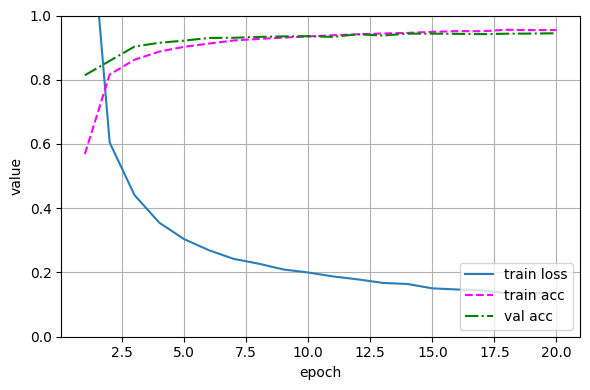

In [25]:
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(6, 4))

plt.plot(epochs_range, train_losses, label='train loss', linestyle='-', color='#2a7db8')
plt.plot(epochs_range, train_accuracies, label='train acc', linestyle='--', color='magenta')
plt.plot(epochs_range, val_accuracies, label='val acc', linestyle='-.', color='green')
plt.xlabel('epoch')
plt.ylabel('value')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

plt.show()

#### Evaluation Metrics

```markdown
In here, the code loads the best-performing model and defines a function to calculate evaluation metrics such as accuracy, precision, recall, and F1 score on the validation set.
```

In [26]:
net.load_state_dict(torch.load('best_model.pth'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4860\2640716579.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [27]:
def cal_metrics(net, iter):
    net.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sentences, pos_tags, lengths in tqdm(iter, desc="Predicting", leave=False):
            sentences = sentences.to(device)
            pos_tags = pos_tags.to(device)
            lengths = lengths.to(device)
            
            predictions = net(sentences)
            predicted_indices = torch.argmax(predictions, dim=-1)
            
            for i in range(sentences.size(0)):
                length = lengths[i]
                pred = predicted_indices[i][:length].cpu().numpy()
                label = pos_tags[i][:length].cpu().numpy()
                all_preds.extend(pred)
                all_labels.extend(label)
    
    pred_labels = [idx2pos[idx] for idx in all_preds if idx != pos2idx['<PAD>']]
    true_labels = [idx2pos[idx] for idx in all_labels if idx != pos2idx['<PAD>']]

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return None

In [28]:
cal_metrics(net, val_iter)

Accuracy: 0.9429
Precision: 0.9426
Recall: 0.9429
F1 Score: 0.9424


#### Prediction

```markdown
In here, the code defines a function to predict POS tags for a given input sequence. It tokenizes the input, converts words to indices, runs the model to obtain predictions, and constructs a parse tree with predicted POS tags. Additionally, it provides descriptions for each unique POS tag in the prediction.
```

In [29]:
def predict_pos_tag(net, word2idx, idx2pos, sequence):
    net.eval()

    pos_descriptions = {
        "CC": "Coordinating Conjunction",
        "CD": "Cardinal Number",
        "DT": "Determiner",
        "EX": "Existential 'There'",
        "FW": "Foreign Word",
        "IN": "Preposition or Subordinating Conjunction",
        "JJ": "Adjective",
        "JJR": "Adjective (Comparative)",
        "JJS": "Adjective (Superlative)",
        "LS": "List Item Marker",
        "MD": "Modal",
        "NN": "Noun (Singular or Mass)",
        "NNS": "Noun (Plural)",
        "NNP": "Proper Noun (Singular)",
        "NNPS": "Proper Noun (Plural)",
        "PDT": "Predeterminer",
        "POS": "Possessive Ending",
        "PRP": "Personal Pronoun",
        "PRP$": "Possessive Pronoun",
        "RB": "Adverb",
        "RBR": "Adverb (Comparative)",
        "RBS": "Adverb (Superlative)",
        "RP": "Particle",
        "SYM": "Symbol",
        "TO": "to",
        "UH": "Interjection",
        "VB": "Verb (Base Form)",
        "VBD": "Verb (Past Tense)",
        "VBG": "Verb (Gerund or Present Participle)",
        "VBN": "Verb (Past Participle)",
        "VBP": "Verb (Non-3rd-Person Singular Present)",
        "VBZ": "Verb (3rd Person Singular Present)",
        "WDT": "Wh-Determiner",
        "WP": "Wh-Pronoun",
        "WP$": "Possessive Wh-Pronoun",
        "WRB": "Wh-Adverb"
    }

    if isinstance(sequence, str):
        words = nltk.word_tokenize(sequence)
    elif isinstance(sequence, list):
        words = sequence
    else:
        raise ValueError

    words_lower = [word.lower() for word in words]
    word_indices = [word2idx.get(word, word2idx['<UNK>']) for word in words_lower]

    input_tensor = torch.tensor([word_indices], dtype=torch.long).to(device)
    lengths = torch.tensor([len(word_indices)], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = net(input_tensor)
        predictions = torch.argmax(logits, dim=-1)

    predicted_pos_indices = predictions[0][:lengths[0]].cpu().numpy()
    predicted_pos_tags = [idx2pos[idx] for idx in predicted_pos_indices]
            
    word_pos_pairs = list(zip(words, predicted_pos_tags))
    tree = Tree('S', [Tree(pos, [word]) for word, pos in word_pos_pairs])
    tree.pretty_print()

    ordered_unique_pos = []
    for pos in predicted_pos_tags:
        if pos not in ordered_unique_pos:
            ordered_unique_pos.append(pos)
        
    print("Description:")
    for pos in ordered_unique_pos:
        description = pos_descriptions.get(pos, "Unknown POS tag")
        print(f"{pos}: {description}")
        
    return tree, description

In [30]:
pos_tree = predict_pos_tag(net, word2idx, idx2pos, "The quick brown fox jumps over the lazy dog")

                      S                    
  ____________________|__________________   
 DT   JJ   NNP  NNP   NN   IN   DT NNP  NNP
 |    |     |    |    |    |    |   |    |  
The quick brown fox jumps over the lazy dog

Description:
DT: Determiner
JJ: Adjective
NNP: Proper Noun (Singular)
NN: Noun (Singular or Mass)
IN: Preposition or Subordinating Conjunction
